In [12]:
import numpy as np
import torch
from torch_geometric.data import Data
import uproot
import os

# Hyperparameters
tree_name = 'Delphes'
delta_r_threshold = 1
NODE_FEAT_DIM = 13  # Each node feature vector length

# Features
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features


# ===================== Helper Functions =====================

def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta ** 2 + delta_phi ** 2)


def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)


def pad_feature_vector(vec, target_dim=NODE_FEAT_DIM):
    """
    Ensure every node has a flat vector of length target_dim.
    """
    flat = []
    for v in vec:
        if hasattr(v, '__len__'):
            if len(v) == 0:
                flat.append(0.0)
            else:
                flat.append(float(v[0]))
        else:
            flat.append(float(v))
    arr = np.array(flat, dtype=np.float32)
    if arr.size >= target_dim:
        return arr[:target_dim]
    else:
        pad = np.zeros(target_dim - arr.size, dtype=np.float32)
        return np.concatenate([arr, pad])


def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    # Edge indices and attributes
    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []

    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index_list.append([i, j])
            edge_attr_list.append([dr])
            edge_target_list.append([1 if dr < delta_r_thresh else 0])

    if not edge_index_list:
        return None

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    # Hyperedges
    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list).astype(np.int64)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list]).astype(np.int64)
    hyperedge_index = torch.from_numpy(np.stack([node_indices, hyperedge_indices])).long()

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t.view(-1, 1),
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.long),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data


# ===================== Load ROOT Data =====================

def load_data_hyper_format(file_path, label):
    if not os.path.exists(file_path):
        print(f"Warning: File {file_path} not found. Skipping...")
        return []

    file = uproot.open(file_path)
    tree = file[tree_name]

    # Load features
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        # --- Jets ---
        jets = []
        for j in range(len(events[jet_features[0]][i])):  # loop over jets
            vec = []
            for feat in jet_features:
                val = events[feat][i][j]
                if hasattr(val, '__len__') and len(val) > 0:
                    val = float(val[0])
                elif hasattr(val, '__len__') and len(val) == 0:
                    val = 0.0
                else:
                    val = float(val)
                vec.append(val)
            jets.append(pad_feature_vector(vec))
        x_jets = np.vstack(jets) if jets else np.zeros((0, NODE_FEAT_DIM))

        # --- Electrons ---
        electrons = []
        for j in range(len(events['Electron.PT'][i])):
            vec = [float(events['Electron.PT'][i][j]),
                   float(events['Electron.Eta'][i][j]),
                   float(events['Electron.Phi'][i][j])]
            electrons.append(pad_feature_vector(vec))
        x_elec = np.vstack(electrons) if electrons else np.zeros((0, NODE_FEAT_DIM))

        # --- Muons ---
        muons = []
        for j in range(len(events['Muon.PT'][i])):
            vec = [float(events['Muon.PT'][i][j]),
                   float(events['Muon.Eta'][i][j]),
                   float(events['Muon.Phi'][i][j])]
            muons.append(pad_feature_vector(vec))
        x_muon = np.vstack(muons) if muons else np.zeros((0, NODE_FEAT_DIM))

        x_leptons = np.vstack([x_elec, x_muon]) if (x_elec.size + x_muon.size) > 0 else np.zeros((0, NODE_FEAT_DIM))

        # --- MET ---
        met_vec = [float(events['MissingET.MET'][i]), float(events['MissingET.Phi'][i])]
        x_met = pad_feature_vector(met_vec).reshape(1, -1)

        # --- Combine all nodes ---
        x_all = np.vstack([x_jets, x_leptons, x_met])
        x_all = normalize_features(x_all)

        # --- Eta & Phi for delta R ---
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        # --- Convert to hypergraph Data ---
        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data is not None:
            data_list.append(data)

    return data_list


C:\Users\sande\AppData\Local\Temp\ipykernel_19580\962539623.py:169: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  met_vec = [float(events['MissingET.MET'][i]), float(events['MissingET.Phi'][i])]


Loaded 4811 Signal samples
Loaded 4609 tt~Z_Bkg samples
Loaded 4337 tt~W_Bkg samples
Loaded 4299 tt~H_Bkg samples
Total dataset size: 18056
Class distribution: {'Signal': 4811, 'tt~Z_Bkg': 4609, 'tt~W_Bkg': 4337, 'tt~H_Bkg': 4299}


c:\ProgramData\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 6GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                      | Params | Mode 
------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


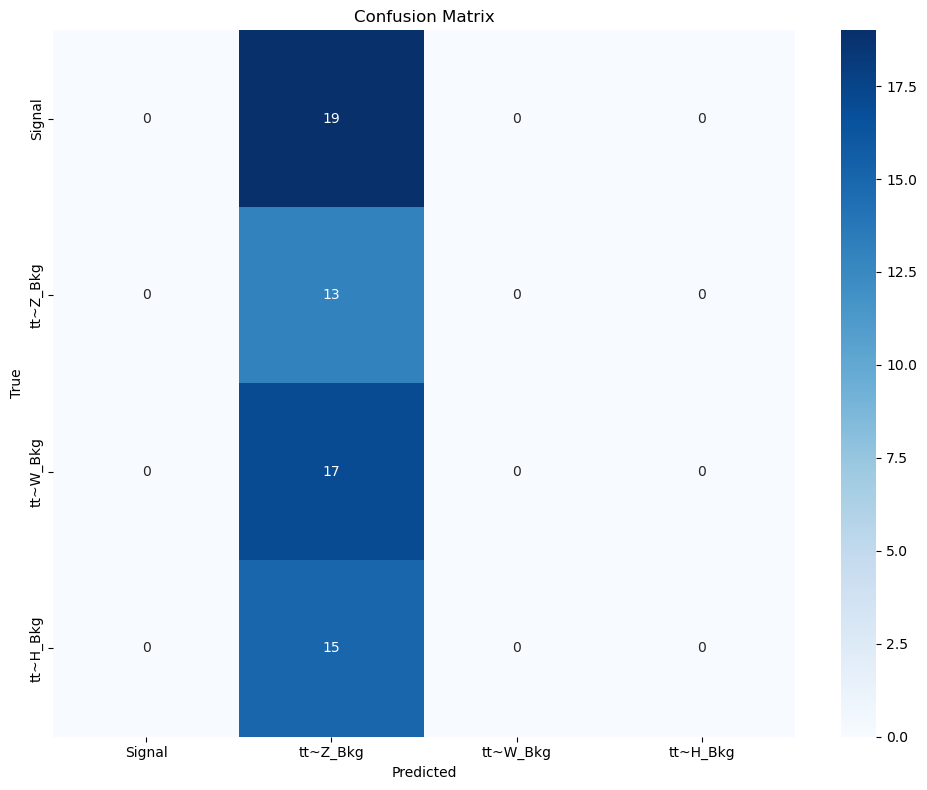

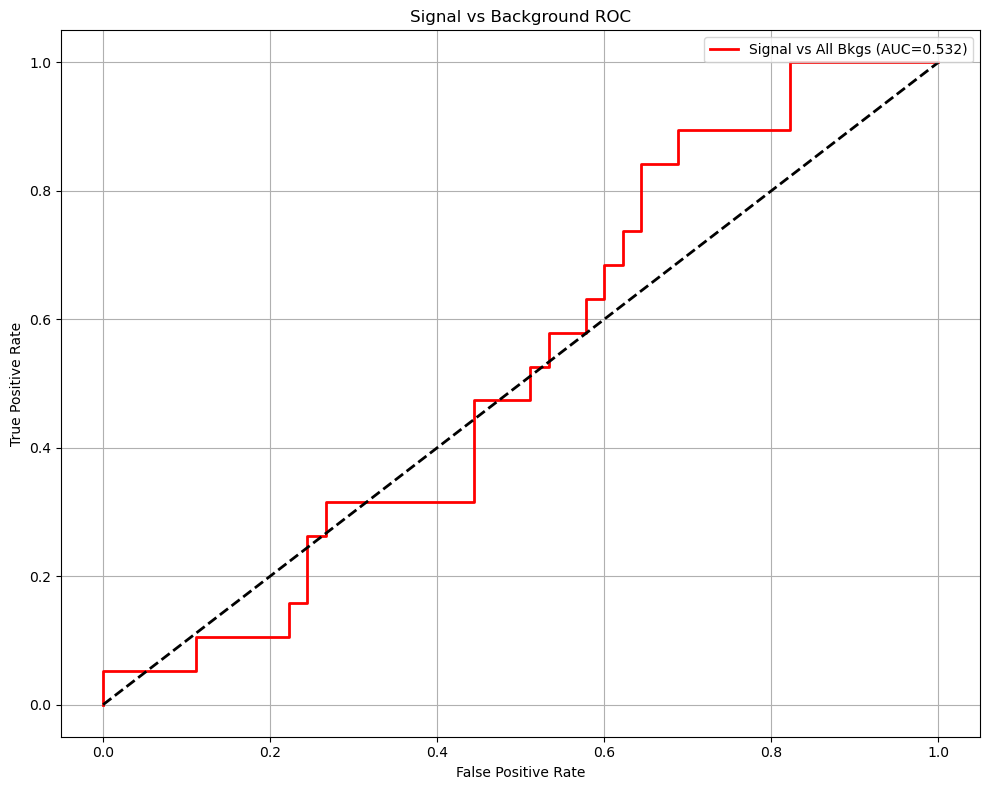

C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

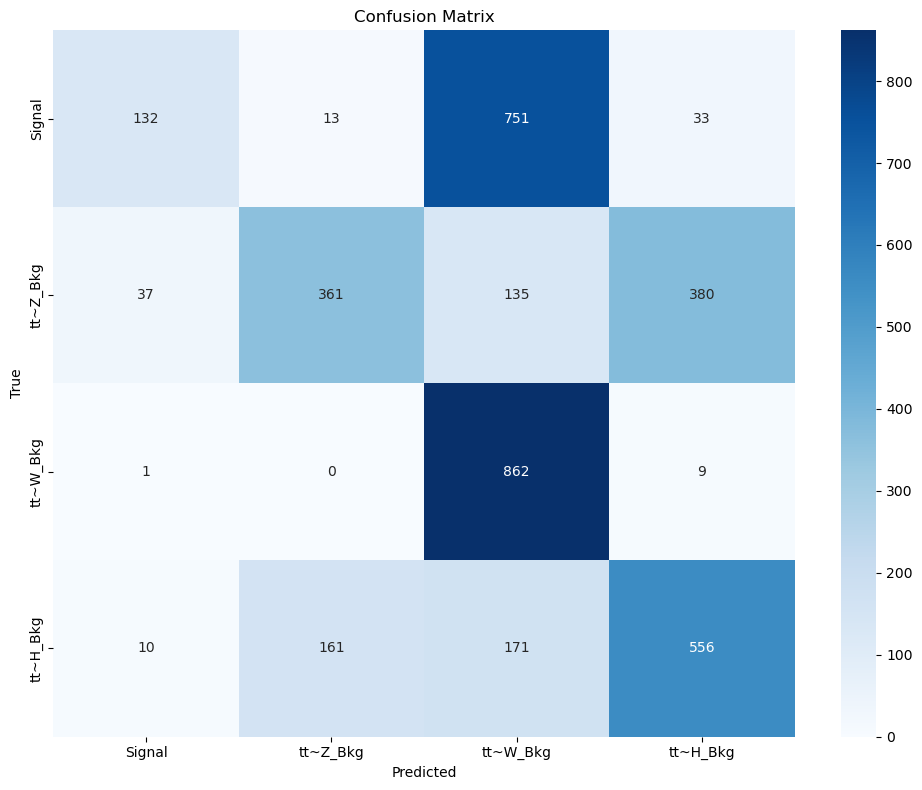

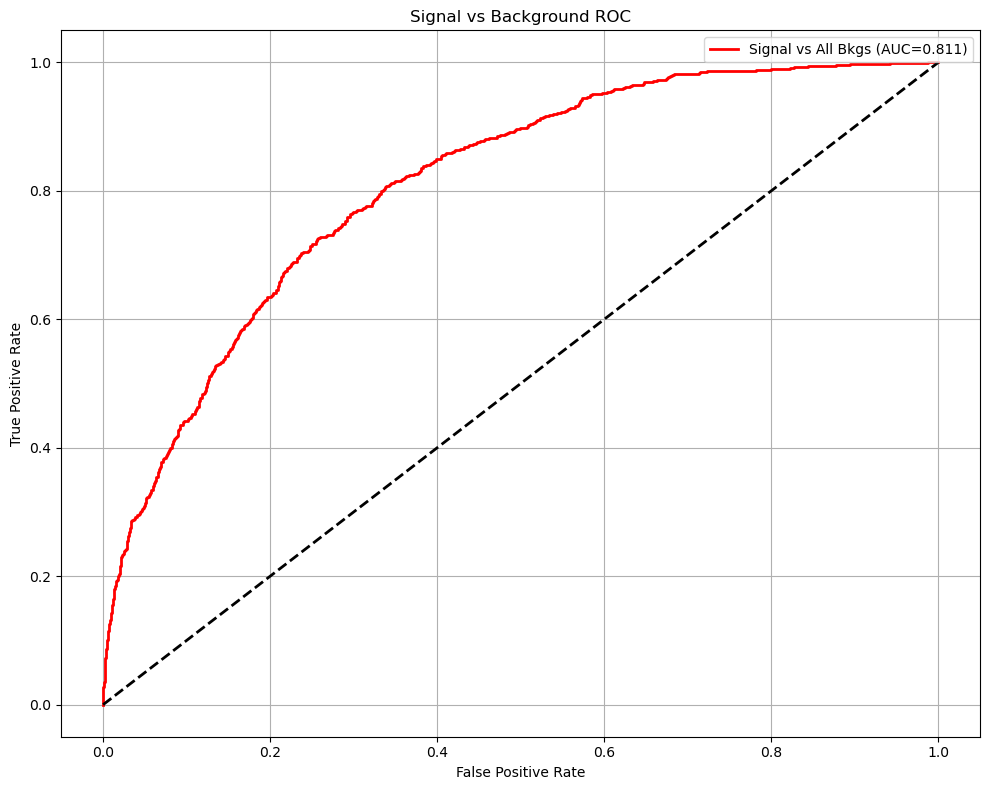

Validation: |          | 0/? [00:00<?, ?it/s]

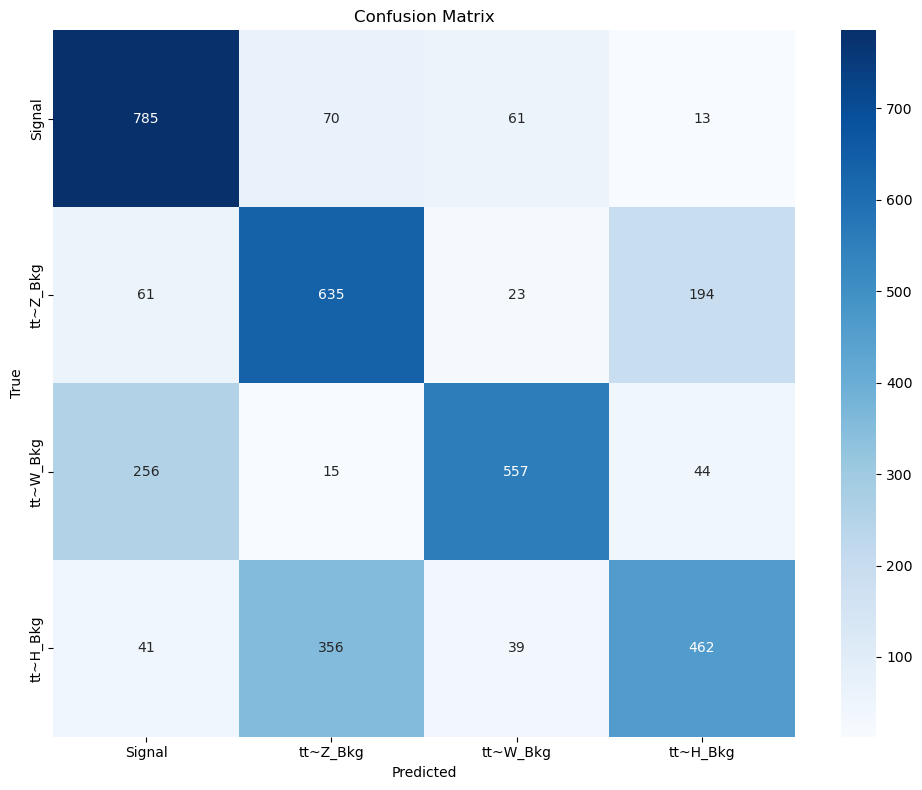

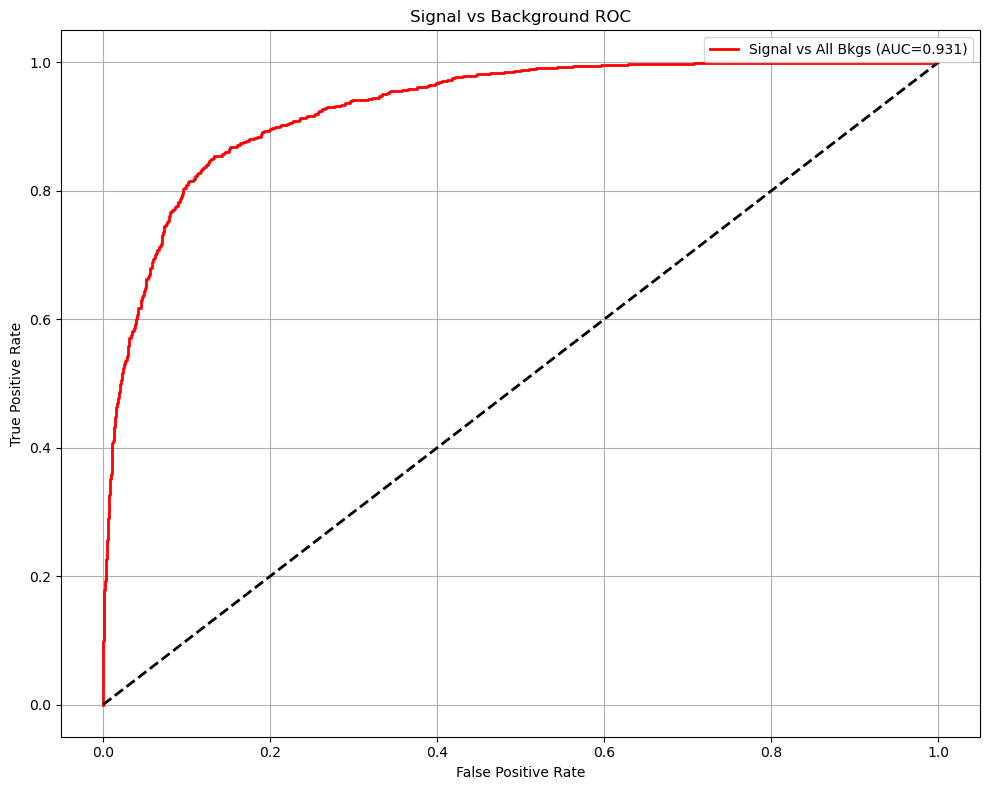

Validation: |          | 0/? [00:00<?, ?it/s]

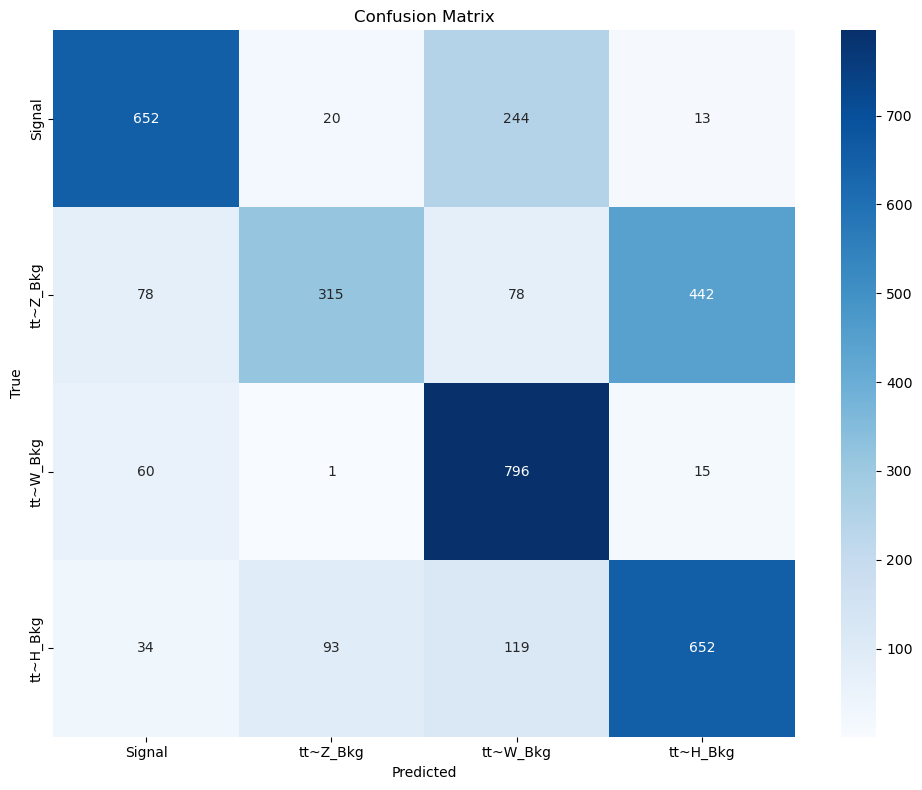

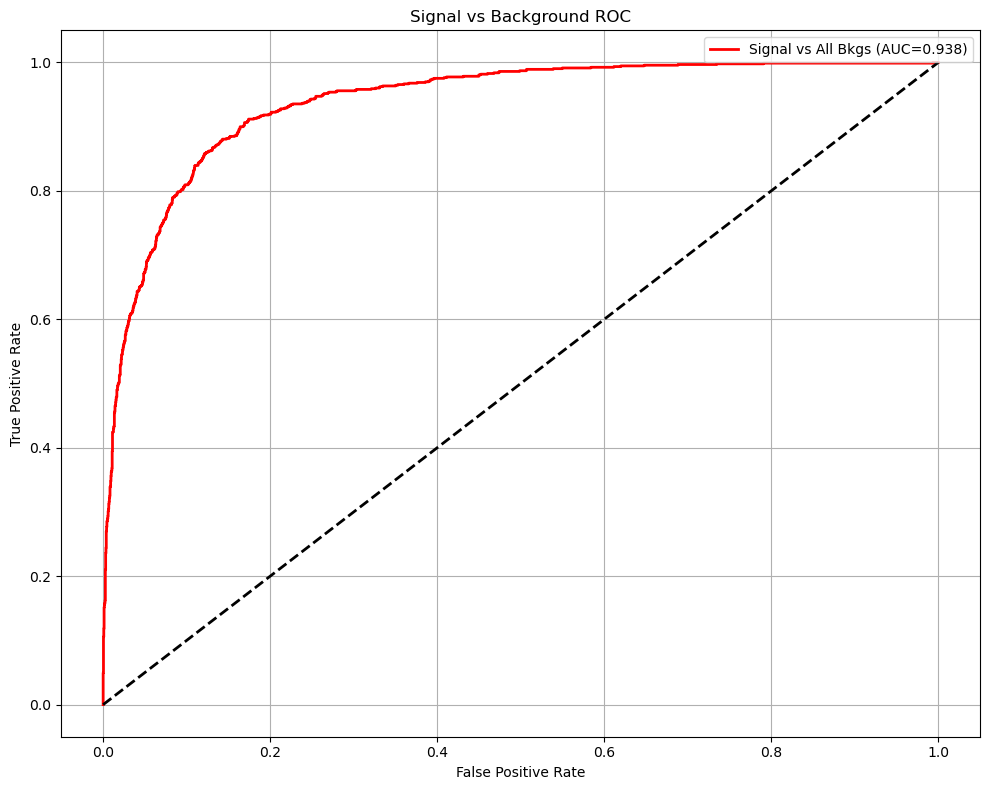

Validation: |          | 0/? [00:00<?, ?it/s]

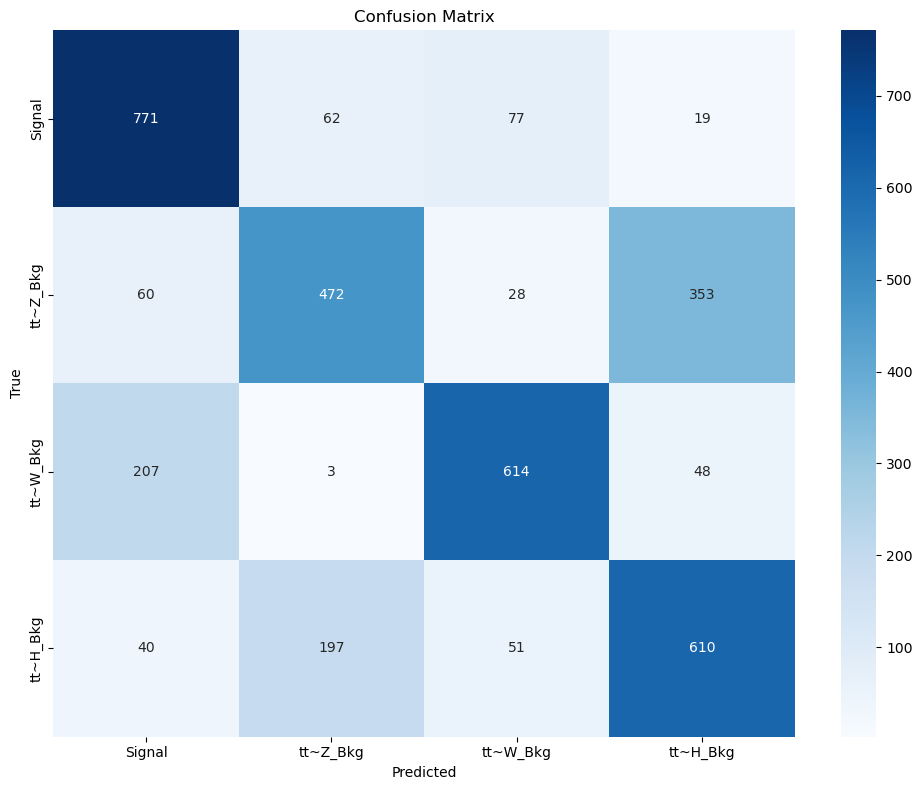

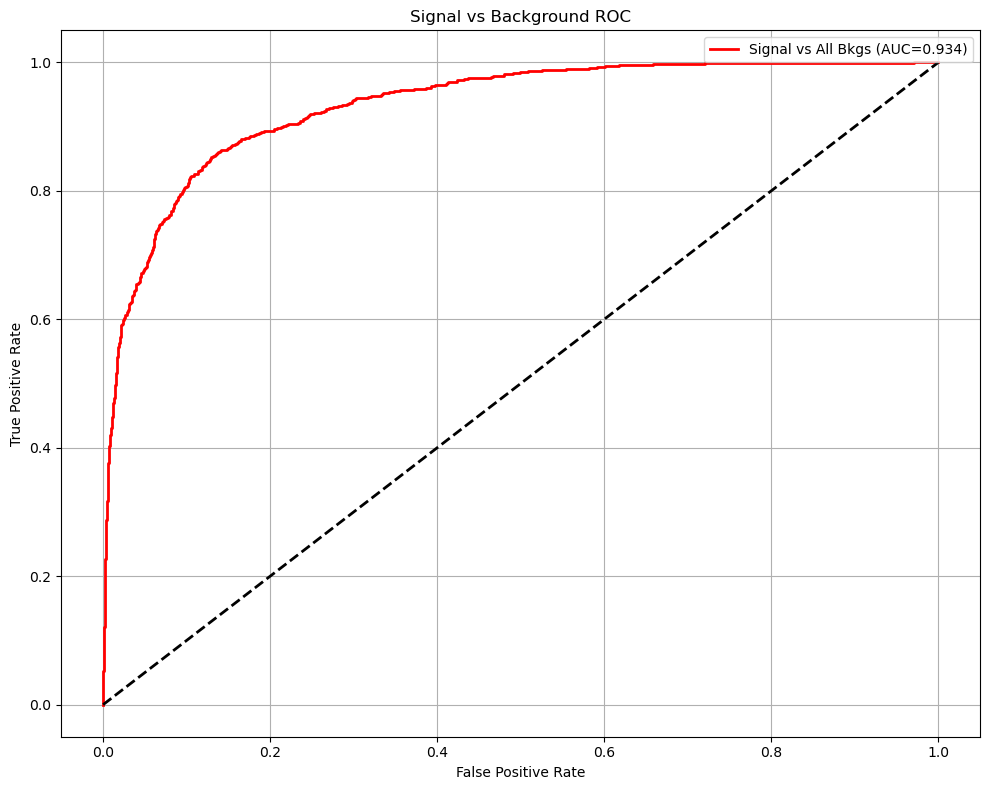

Validation: |          | 0/? [00:00<?, ?it/s]

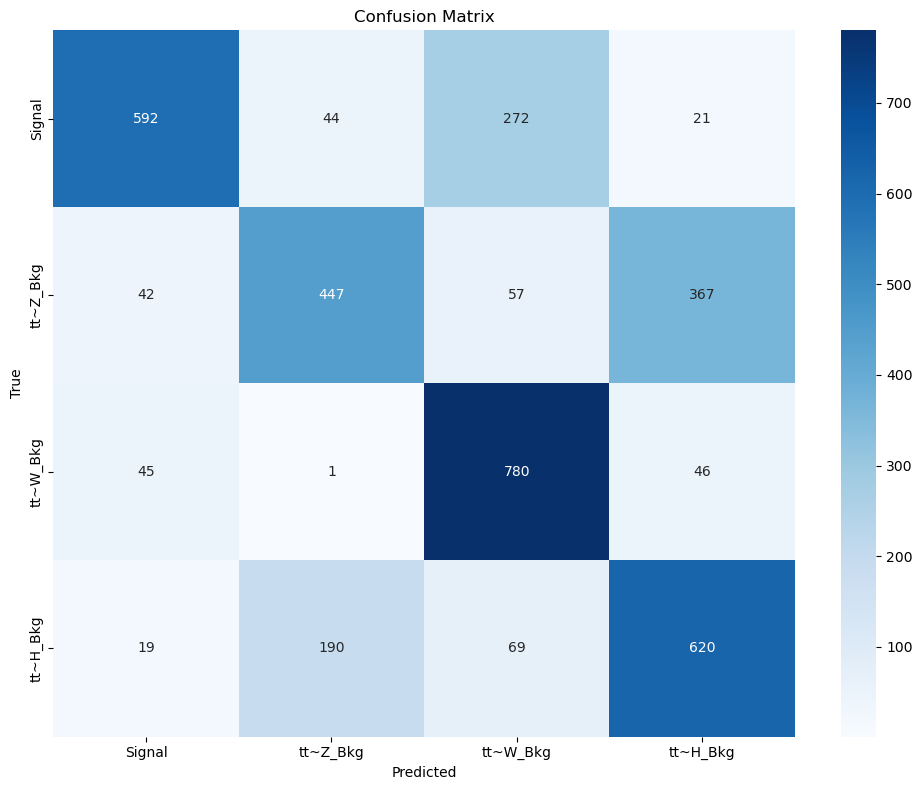

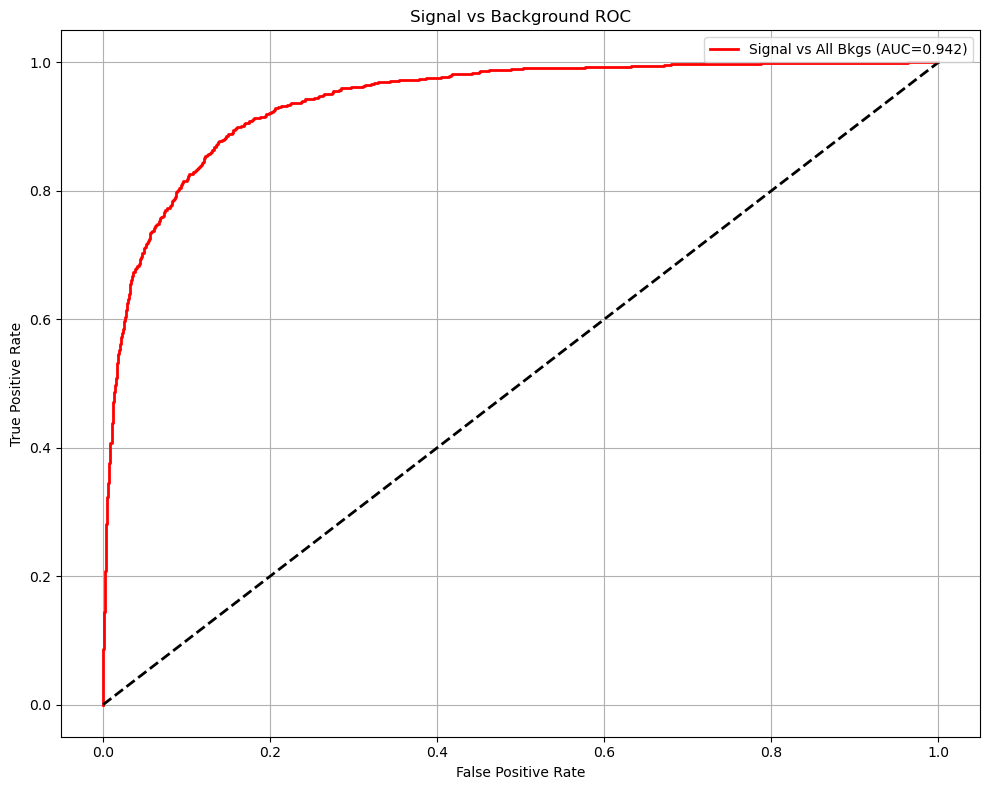

Validation: |          | 0/? [00:00<?, ?it/s]

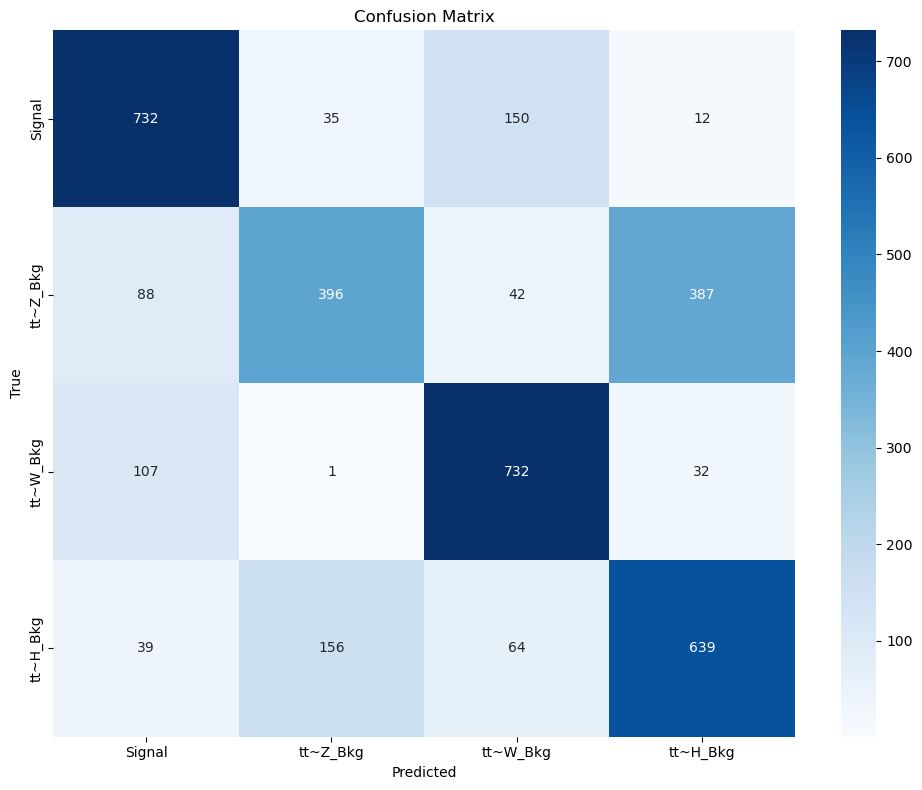

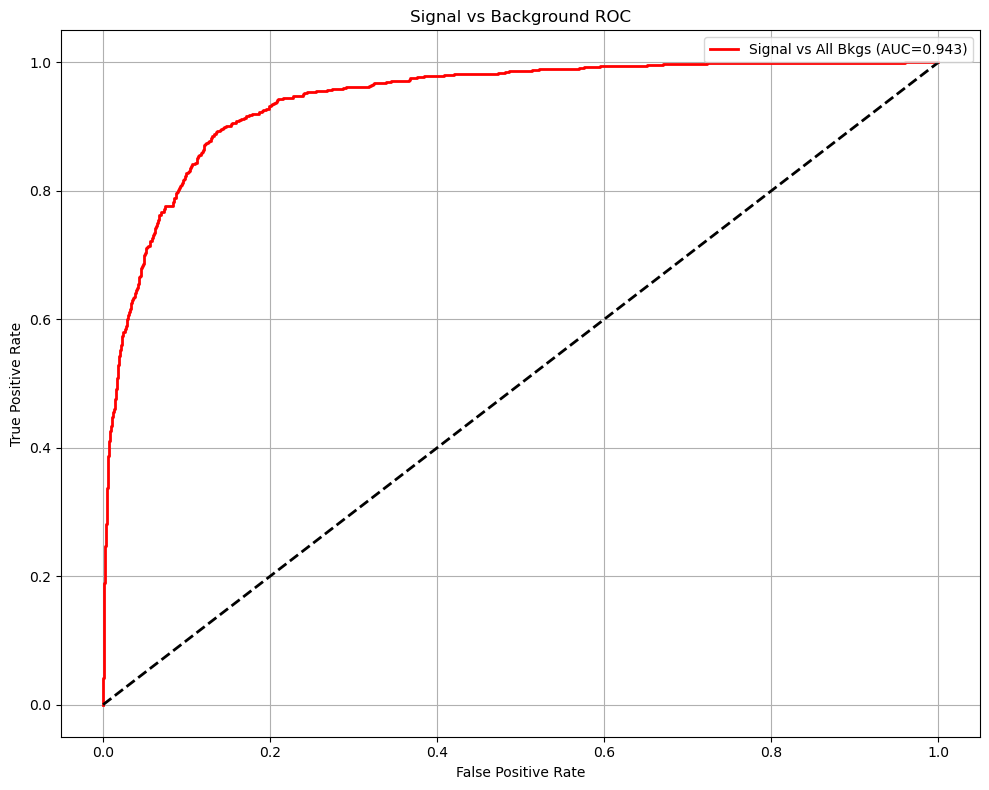

Validation: |          | 0/? [00:00<?, ?it/s]

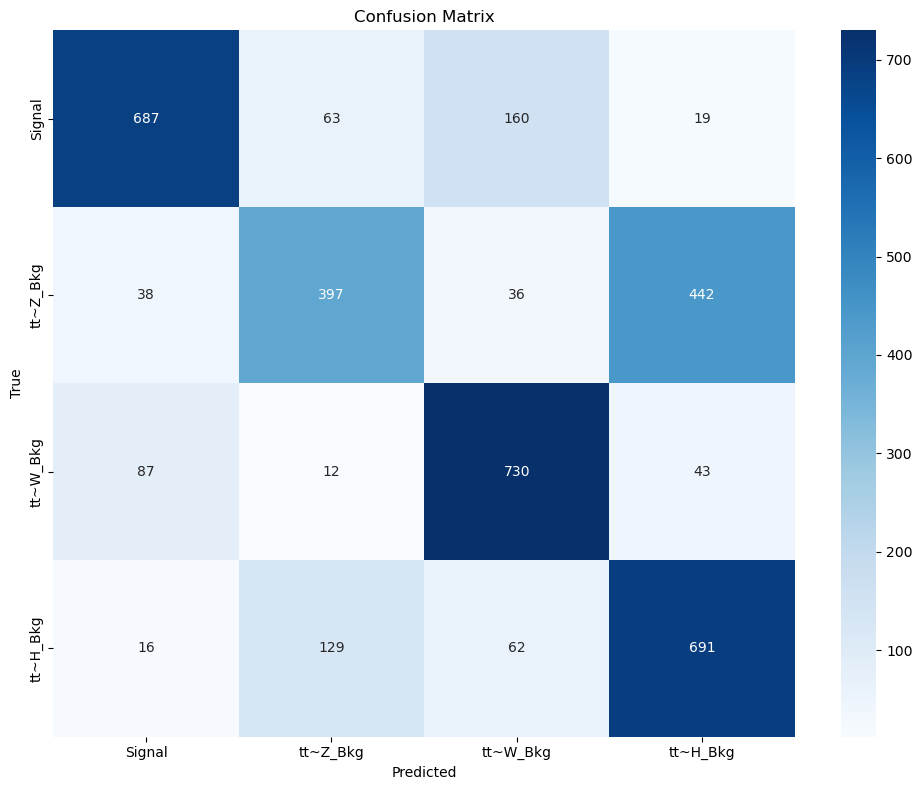

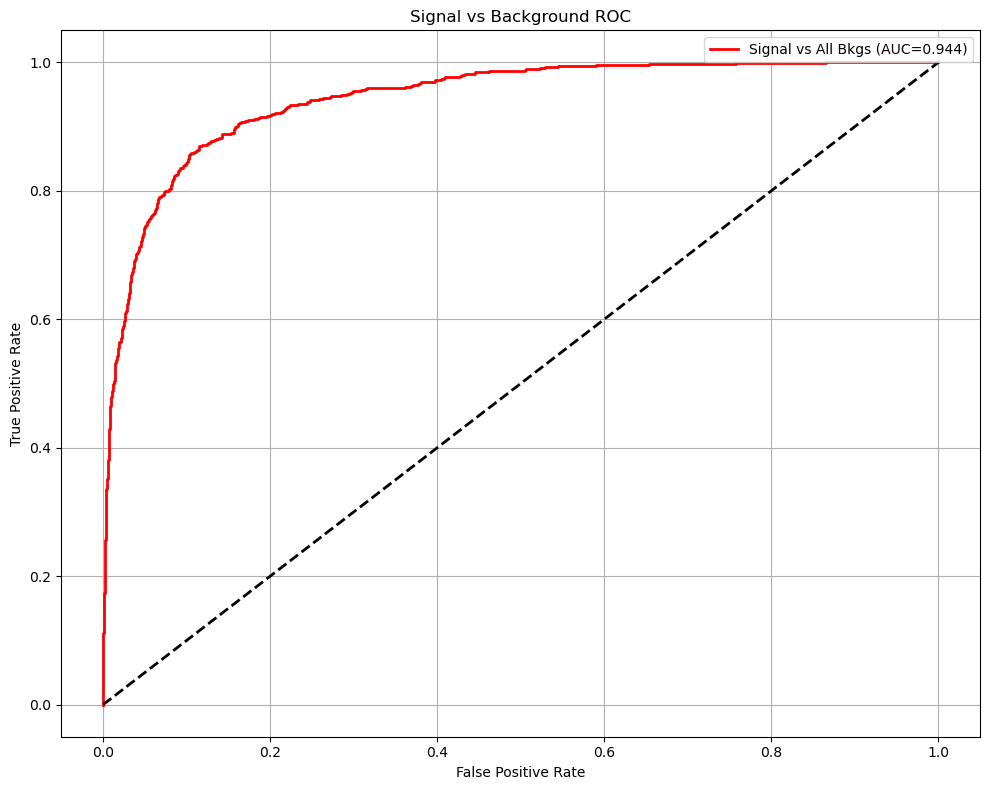

Validation: |          | 0/? [00:00<?, ?it/s]

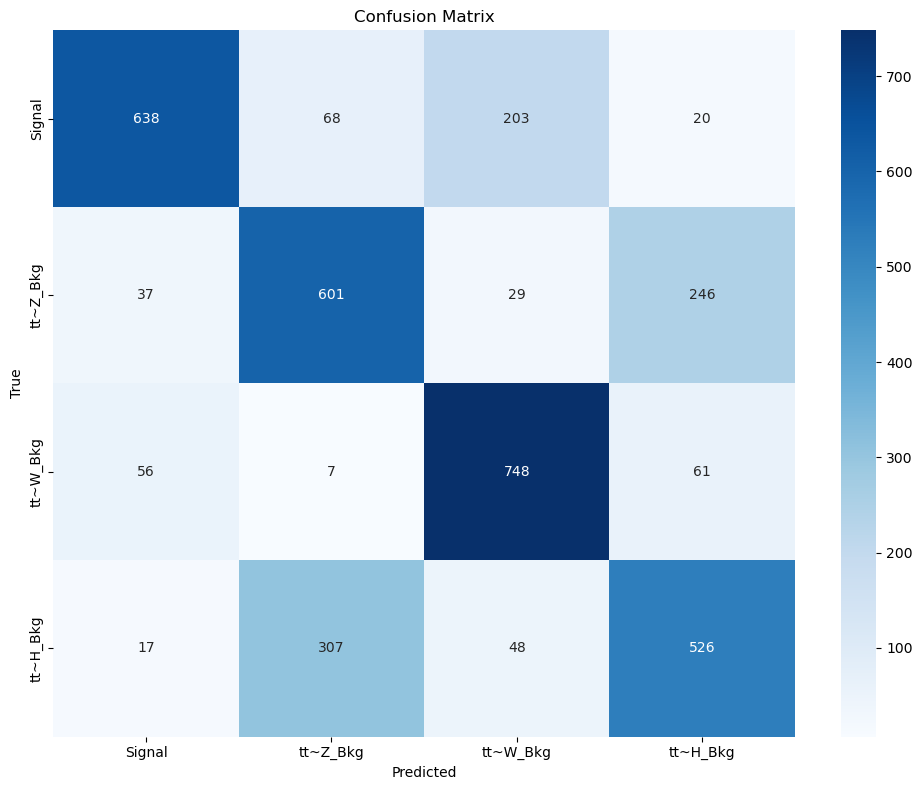

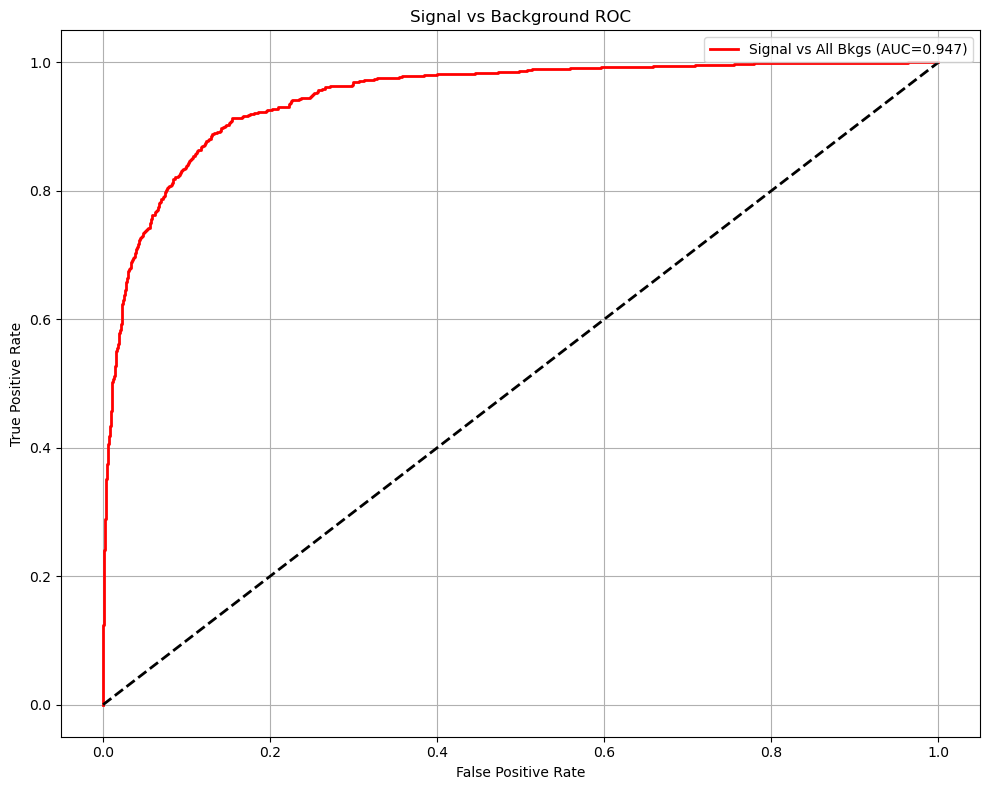

Validation: |          | 0/? [00:00<?, ?it/s]

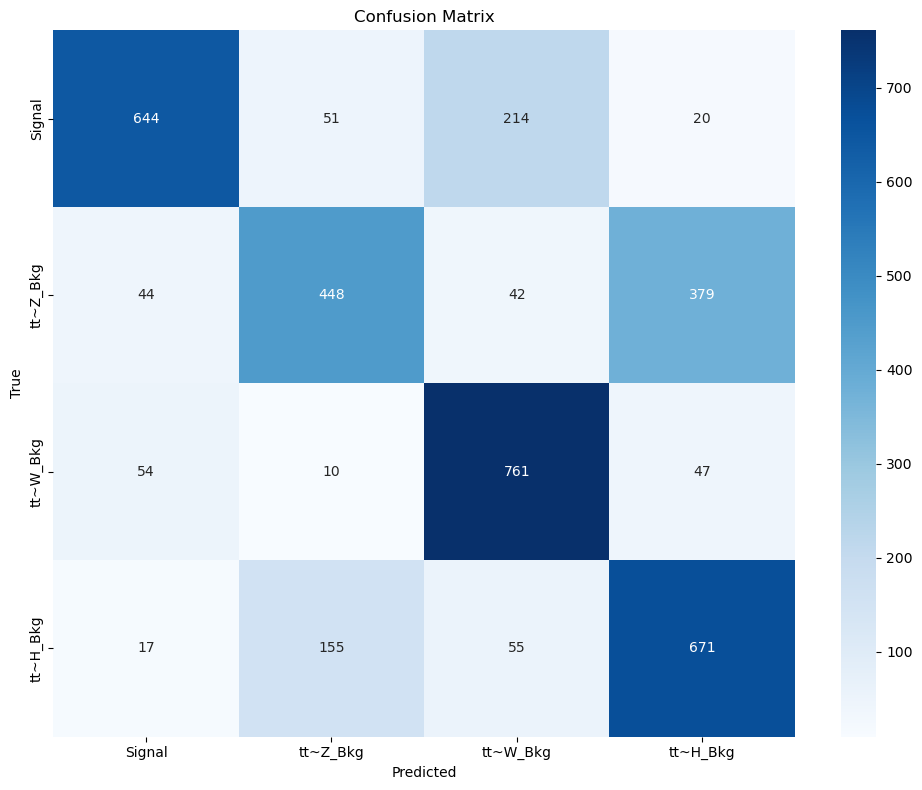

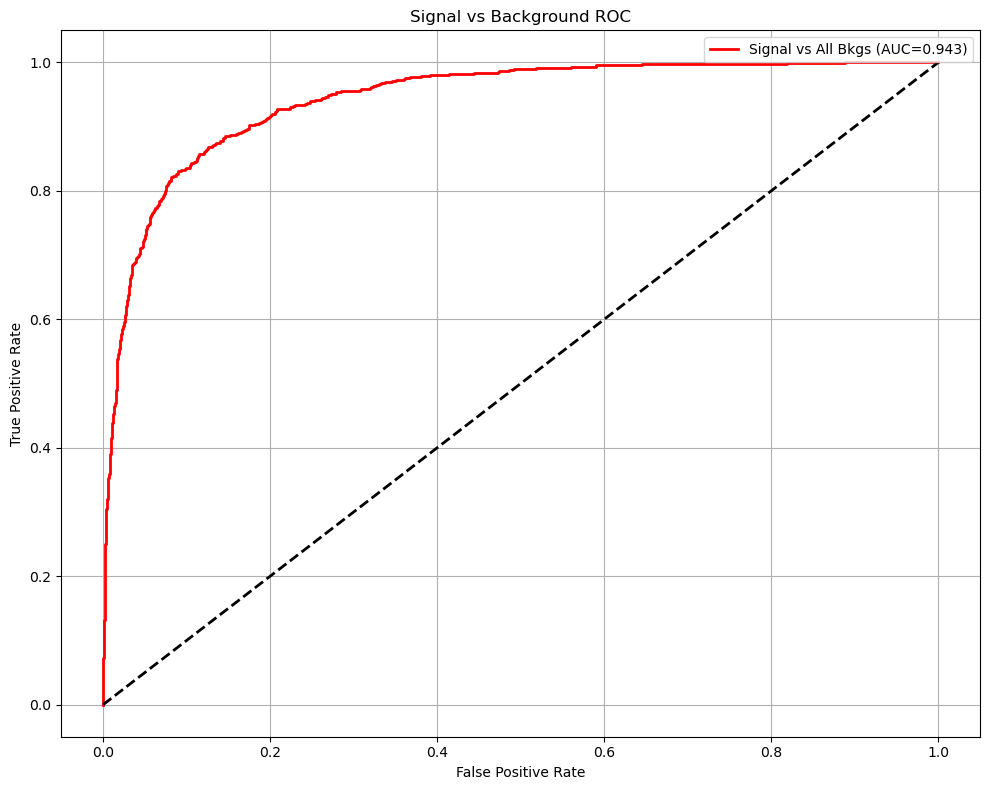

Validation: |          | 0/? [00:00<?, ?it/s]

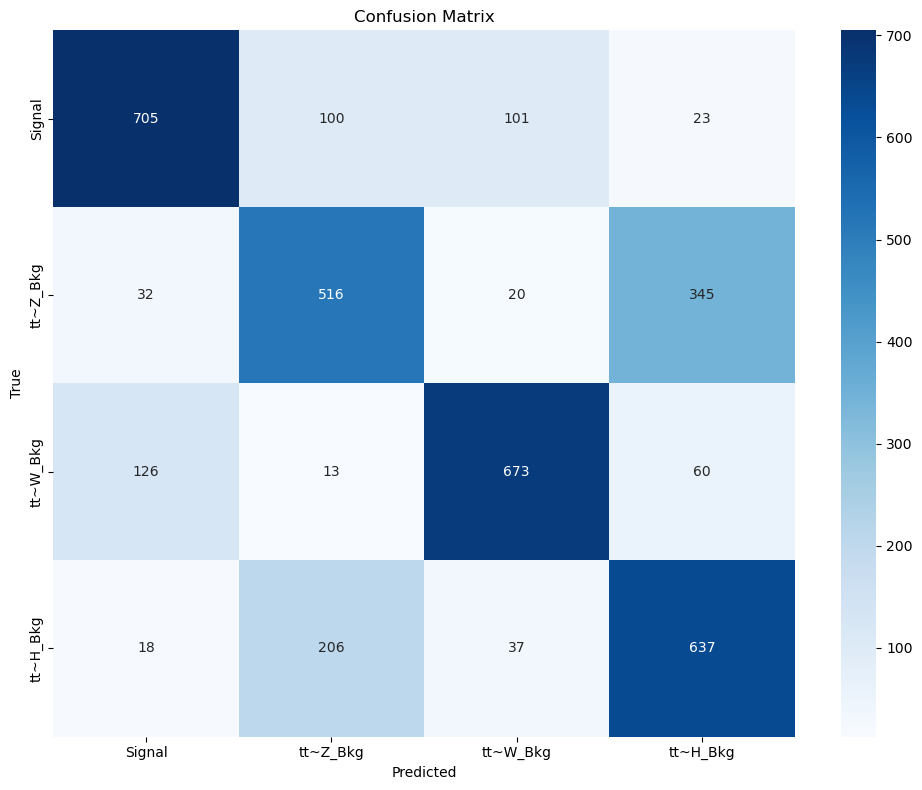

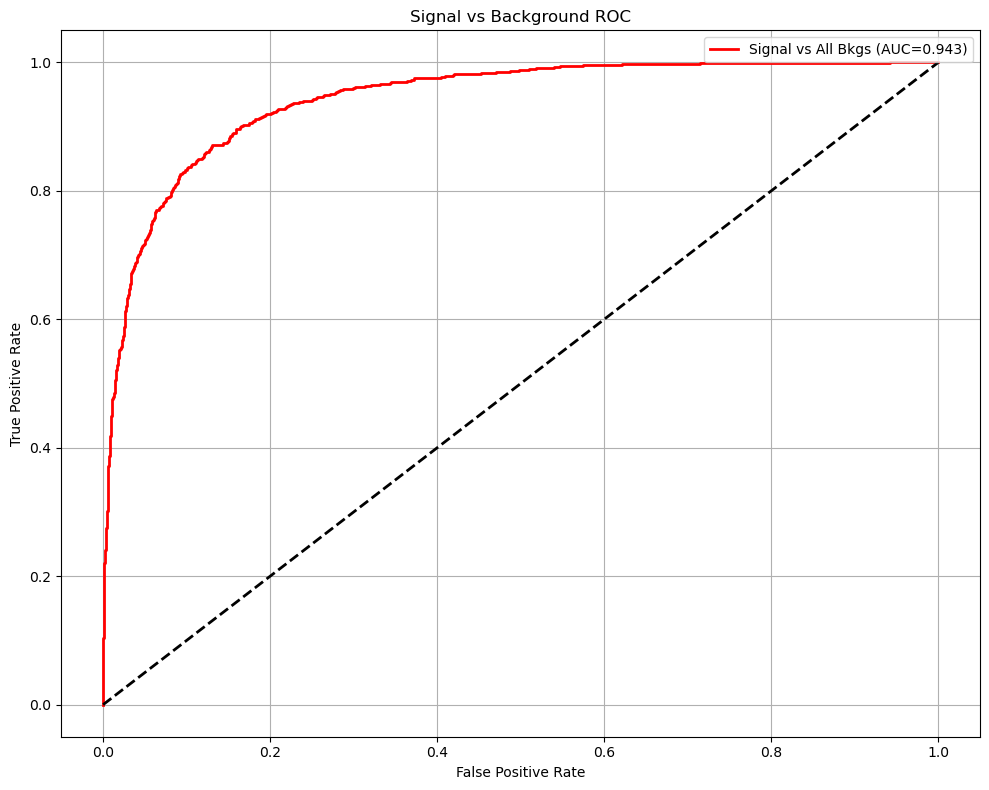

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
import os
import numpy as np
import torch
from torch_geometric.data import DataLoader
import joblib
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss, Softmax
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# HyPER imports (assuming installed)
from HyPER.models import MPNNs, EdgeLoss, CombinedLoss

# ===================== Config =====================
os.makedirs("results", exist_ok=True)

jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

data_files = {
    'signal': 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root',
    'tt~H_Bkg': 'C:/Users/sande/Desktop/project rootfiles/ttbarH.root',
    'tt~Z_Bkg': 'C:/Users/sande/Desktop/project rootfiles/ttbarZ.root',
    'tt~W_Bkg': 'C:/Users/sande/Desktop/project rootfiles/ttbarW.root'
}

class_names = ['Signal', 'tt~Z_Bkg', 'tt~W_Bkg', 'tt~H_Bkg']
num_classes = len(class_names)
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
signal_class = 0
background_classes = list(range(1, num_classes))
batch_size = 32
delta_r_threshold = 1
NODE_FEAT_DIM = 13
tree_name = 'Delphes'


# ===================== Load Dataset =====================
dataset = []
class_sample_counts = {}

# Signal
signal_data = load_data_hyper_format(data_files['signal'], signal_class)
dataset.extend(signal_data)
class_sample_counts['Signal'] = len(signal_data)
print(f"Loaded {len(signal_data)} Signal samples")

# Backgrounds
for i, (bkg_name, file_path) in enumerate([item for item in data_files.items() if item[0] != 'signal']):
    bkg_label = i + 1
    bkg_data = load_data_hyper_format(file_path, bkg_label)
    dataset.extend(bkg_data)
    class_sample_counts[class_names[bkg_label]] = len(bkg_data)
    print(f"Loaded {len(bkg_data)} {class_names[bkg_label]} samples")

print(f"Total dataset size: {len(dataset)}")
print("Class distribution:", class_sample_counts)

# Shuffle & split
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data, test_data = dataset[:split], dataset[split:]

# Class weights
train_labels = [d.x_t.item() for d in train_data]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.FloatTensor(class_weights)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# TensorBoard logger
logger = TensorBoardLogger("lightning_logs", name="hypergraph_signal_vs_bkgs")


# ===================== Hyperedge Model =====================
class SignalVsBkgHyperedgeModel(torch.nn.Module):
    """Custom hyperedge model for signal vs multiple backgrounds classification"""
    def __init__(self, node_in_channels, global_in_channels, message_feats, dropout, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.node_transform = torch.nn.Linear(node_in_channels, message_feats)
        self.global_transform = torch.nn.Linear(global_in_channels, message_feats)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(message_feats*2, message_feats),
            torch.nn.BatchNorm1d(message_feats),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(message_feats, message_feats//2),
            torch.nn.BatchNorm1d(message_feats//2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(message_feats//2, num_classes)
        )

    def forward(self, x, u, batch):
        x_t = self.node_transform(x)
        u_t = self.global_transform(u)
        hyperedge_features = []
        for i in range(len(u)):
            mask = batch == i
            nodes = x_t[mask]
            if len(nodes) > 0:
                combined = torch.cat([nodes.mean(0), u_t[i]])
                hyperedge_features.append(combined)
        if hyperedge_features:
            hyperedge_features = torch.stack(hyperedge_features)
            logits = self.classifier(hyperedge_features)
        else:
            logits = torch.zeros((len(u), self.num_classes))
        return logits


# ===================== Lightning Module =====================
class SignalVsBkgHyPERModel(LightningModule):
    def __init__(self, num_classes=num_classes, class_weights=None):
        super().__init__()
        self.num_classes = num_classes
        self.signal_class = signal_class
        self.background_classes = background_classes

        # HyPER MPNN model
        self.model = MPNNs(
            node_in_channels=NODE_FEAT_DIM,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.01,
            activation=torch.nn.ReLU(),
            p_out='edge'
        )

        # Hyperedge classifier
        self.hyper = SignalVsBkgHyperedgeModel(
            node_in_channels=32,
            global_in_channels=32,
            message_feats=32,
            dropout=0.01,
            num_classes=num_classes
        )

        self.criterion_edge = BCEWithLogitsLoss(reduction='none')
        self.criterion_hyper = CrossEntropyLoss(weight=class_weights)
        self.alpha = 0.5
        self.softmax = Softmax(dim=1)

        # Store outputs for metrics
        self.y_true, self.y_pred, self.y_prob = [], [], []

    def forward(self, data):
        x, edge_attr, u = self.model(data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch)
        logits = self.hyper(x, u, data.batch)
        return logits, edge_attr

    def training_step(self, batch, batch_idx):
        logits, edge_attr_prime = self.forward(batch)
        loss_hyper = self.criterion_hyper(logits, batch.x_t.long())
        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )
        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean')
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        logits, edge_attr_prime = self.forward(batch)

        probs = self.softmax(logits)
        preds = torch.argmax(logits, dim=1)

        self.y_true.extend(batch.x_t.detach().cpu().numpy())
        self.y_pred.extend(preds.detach().cpu().numpy())
        self.y_prob.extend(probs.detach().cpu().numpy())

        # Step-level accuracy
        acc = (preds == batch.x_t.long()).float().mean()
        self.log('val_step_acc', acc, prog_bar=False, on_step=True, on_epoch=False)

        return {"val_loss": self.criterion_hyper(logits, batch.x_t.long())}

    def on_validation_epoch_end(self):
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                                     f1_score, roc_auc_score, confusion_matrix, roc_curve)
        from sklearn.preprocessing import label_binarize
        import joblib
        import numpy as np

        y_true = np.array(self.y_true)
        y_pred = np.array(self.y_pred)
        y_prob = np.array(self.y_prob)

        # --- Multi-class metrics ---
        acc = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

        try:
            if len(np.unique(y_true)) > 1:
                y_true_bin = label_binarize(y_true, classes=range(self.num_classes))
                roc_auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
            else:
                roc_auc = 0.0
        except:
            roc_auc = 0.0

        # --- Signal vs All Backgrounds ---
        y_true_bin = (y_true == self.signal_class).astype(int)
        signal_prob = y_prob[:, self.signal_class]
        signal_auc = roc_auc_score(y_true_bin, signal_prob) if len(np.unique(y_true_bin)) > 1 else 0.0
        signal_f1 = f1_score(y_true_bin, (y_pred == self.signal_class).astype(int), zero_division=0)

        # Log metrics for scheduler
        self.log('val_signal_auc', signal_auc, prog_bar=True)
        self.log('val_signal_f1', signal_f1)
        self.log('val_accuracy', acc)

        # --- Confusion matrix ---
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.savefig("results/Multi_confusion_matrix.png")
        plt.show()
        plt.close()

        # --- ROC Curve Signal vs Background ---
        fpr, tpr, _ = roc_curve(y_true_bin, signal_prob)
        plt.figure(figsize=(10,8))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'Signal vs All Bkgs (AUC={signal_auc:.3f})')
        plt.plot([0,1],[0,1],'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Signal vs Background ROC')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()
        plt.savefig("results/signal_vs_all_bkgs_roc.png")
        plt.close()

        # Clear lists for next epoch
        self.y_true.clear()
        self.y_pred.clear()
        self.y_prob.clear()

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=10, verbose=True)
        return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": scheduler, "monitor": "val_signal_auc"}}

model = SignalVsBkgHyPERModel(num_classes=num_classes, class_weights=class_weights)
trainer = Trainer(max_epochs=10, accelerator='auto', logger=logger, gradient_clip_val=1.0)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)
